In [1]:
import os
import cv2
import numpy as np
import math
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from PIL import Image, ImageEnhance 
from pylab import arange, show, cm

In [2]:
def con2(img,scalingFac):

    average = img.mean(axis=0).mean(axis=0)*scalingFac

    MIN = np.array([0,0,0], np.uint8)
    MAX = np.array(average, np.uint8)


    dstr = cv2.inRange(img, MIN, MAX)
    no_cov = cv2.countNonZero(dstr)
    frac_cov = np.divide(no_cov, height*width)
    percent_cov = np.multiply((1-frac_cov), 100)
    
    image = dstr
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] != 0:
                image[i,j] = 0
            else:
                image[i,j] = 1


    #image = ndimage.binary_fill_holes(image).astype(int)

    image = np.where(image==1, 255, image) 
    cv2.imwrite('temp.png', image)
    img= cv2.imread('temp.png',1)


    img = cv2.bitwise_not(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=1)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]


    unique, counts = np.unique(markers, return_counts=True)
    tagDict3 = dict(zip(unique, counts))
    markers = np.where(markers==1, np.nan, markers)
    
    return markers, tagDict3, percent_cov

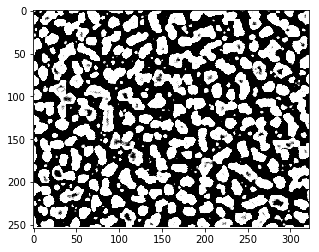

Segmentation: 
Coverage: 50.131%
Agglomerations: 151(Cutoff area = 0.744 μm^2)
Median size: 2.603 μm^2
Average size: 7.824 μm^2


<Figure size 432x288 with 0 Axes>

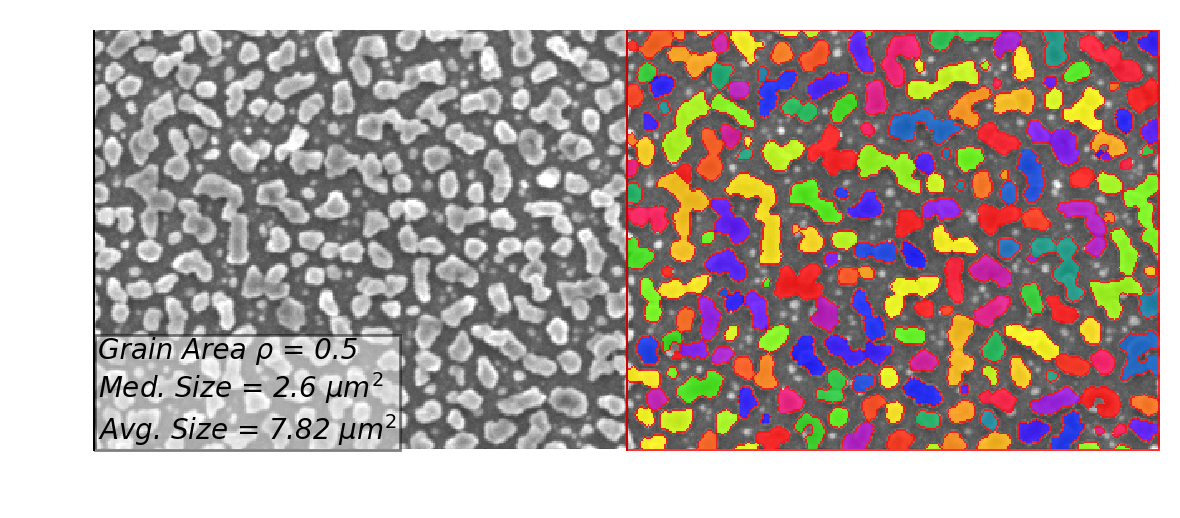

<Figure size 432x288 with 0 Axes>

In [5]:
directory = "/Volumes/GoogleDrive/My Drive/IEC/Prec Paper 2020/SEM Quant"
os.chdir(directory)

#3000x 10um = 82px
scale = 10/82
scalingFac = 0.85
scalingFac2 = .85
pixCut = 50

imgName = '25GaSeq3000SEM'

im = Image.open(''.join([imgName,'.png']))
enhancer = ImageEnhance.Contrast(im)
enhanced_im = enhancer.enhance(10.0)
enhanced_im.save("temp.png")

plt.imshow(enhanced_im)
plt.show()
plt.clf()

img = cv2.imread(''.join(['temp','.png']))
size = img.size
height, width, channels = img.shape

imgDef = img = cv2.imread(''.join([imgName,'.png']))



markers, tagDict2, percent_cov = con2(img,scalingFac2)


aggArea2 = np.array(list(tagDict2.values()))

areaClip2 = aggArea2[(aggArea2>pixCut)]
areaum2 = [i * scale**2 for i in areaClip2]

areaum2 = [round(num, 4) for num in areaum2]


print('Segmentation: ')
print('Coverage: ' + str(round(sum(np.delete(areaClip2,1))/(height*width)*100,3)) + '%')
print('Agglomerations: ' + str(len(areaClip2[2:])) + '(Cutoff area = ' + str(round(pixCut*scale**2,3)) +' μm^2)')
print('Median size: ' + str(round(np.median(areaum2),3)) + ' μm^2')
print('Average size: ' + str(round(np.average(areaum2),3)) + ' μm^2')


fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, dpi=200)
axs[0].imshow(imgDef)
axs[1].imshow(imgDef)
axs[1].imshow(markers, alpha=.8,cmap='prism')
axs[0].axis('off')
axs[1].axis('off')


axs[0].text(0.01,0.025, ''.join(['Grain Area ρ = ',str(round(sum(np.delete(areaClip2,1))/(height*width),2)),'\n',
                             'Med. Size = ',str(round(np.median(areaum2),2)), ' $μm^2$','\n',
                            'Avg. Size = ',str(round(np.average(areaum2),2)), ' $μm^2$']), style='italic',transform=axs[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})



plt.tight_layout()
plt.savefig(''.join([imgName,'-Quant']),bbox_inches='tight',dpi=250)
plt.show()
plt.clf()

